In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
import geopandas as gpd
import matplotlib.ticker as ticker

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/corona-virus-brazil/brazil_covid19.csv
/kaggle/input/corona-virus-brazil/brazil_covid19_old.csv
/kaggle/input/brazilianstatesshapefiles/BRA_adm1.csv
/kaggle/input/brazilianstatesshapefiles/BRA_adm1.shp
/kaggle/input/brazilianstatesshapefiles/BRA_adm1.prj
/kaggle/input/brazilianstatesshapefiles/BRA_adm1.dbf
/kaggle/input/brazilianstatesshapefiles/BRA_adm1.cpg
/kaggle/input/brazilianstatesshapefiles/BRA_adm1.shx


In [2]:
data = pd.read_csv('../input/corona-virus-brazil/brazil_covid19.csv')
data.head()

date        region               state  cases  deaths
0  2020-01-30  Centro-Oeste    Distrito Federal      0       0
1  2020-01-30  Centro-Oeste               Goiás      0       0
2  2020-01-30  Centro-Oeste         Mato Grosso      0       0
3  2020-01-30  Centro-Oeste  Mato Grosso do Sul      0       0
4  2020-01-30      Nordeste             Alagoas      0       0

In [3]:
data.isna().sum()

date      0
region    0
state     0
cases     0
deaths    0
dtype: int64

## By day

In [4]:
cases_day = pd.DataFrame(data.groupby(['date']).sum().reset_index())
cases_day['date'] = cases_day['date'].apply(lambda x: '{:%m-%d}'.format(dt.strptime(x, '%Y-%m-%d')))
cases_day

date  cases  deaths
0   01-30      0       0
1   01-31      0       0
2   02-01      0       0
3   02-02      0       0
4   02-03      0       0
..    ...    ...     ...
87  04-26  61888    4205
88  04-27  66501    4543
89  04-28  71886    5017
90  04-29  78162    5466
91  04-30  85380    5901

[92 rows x 3 columns]

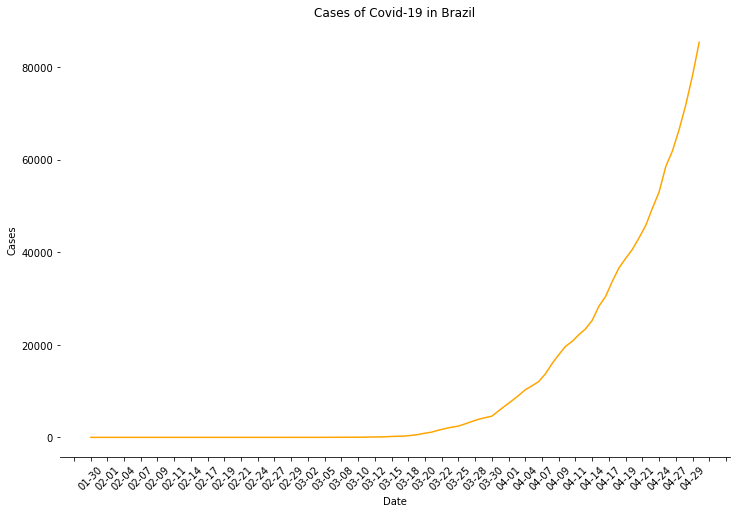

In [5]:
plt.figure(figsize=(12,8))
plt.title("Cases of Covid-19 in Brazil")
plt.xticks(rotation=45)


sns.set_style("whitegrid")
sns.despine(left=True)
fig = sns.lineplot(x=cases_day['date'], y=cases_day['cases'], color='orange')
fig.set_xlabel('Date')
fig.set_ylabel('Cases')
fig.xaxis.set_major_locator(ticker.MaxNLocator(46))

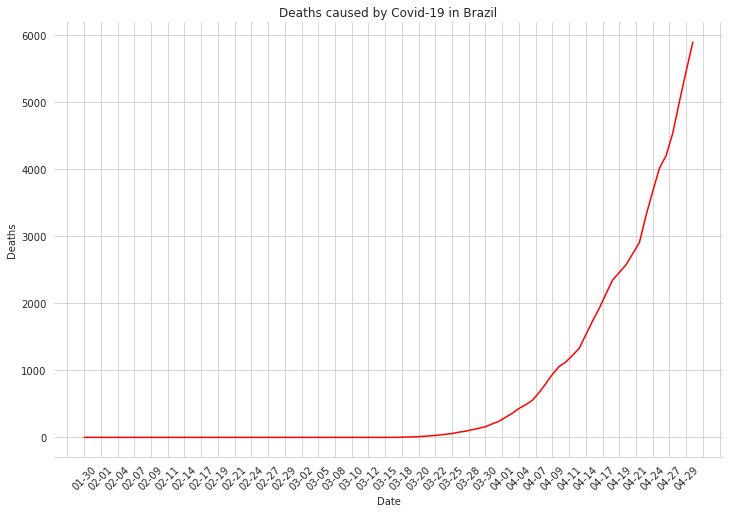

In [6]:
plt.figure(figsize=(12,8))
plt.title("Deaths caused by Covid-19 in Brazil")
plt.xticks(rotation=45)

sns.set_style("whitegrid")
sns.despine(left=True)
fig = sns.lineplot(x=cases_day['date'], y=cases_day['deaths'], color='red')
fig.set_xlabel('Date')
fig.set_ylabel('Deaths')
fig.xaxis.set_major_locator(ticker.MaxNLocator(46))

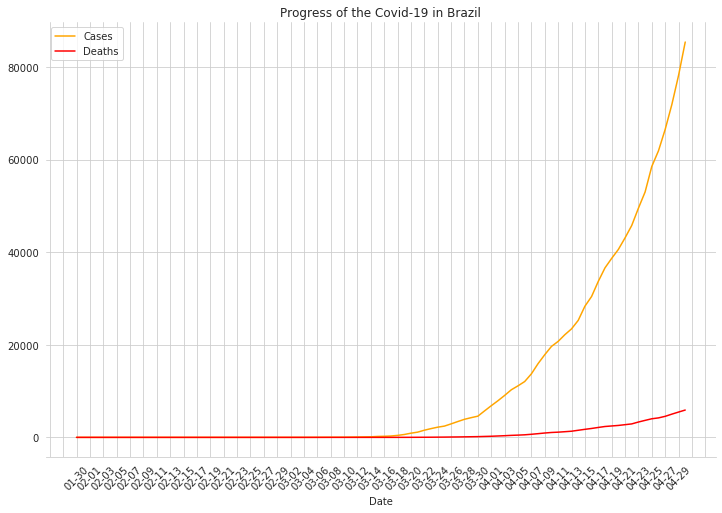

In [7]:
plt.figure(figsize=(12,8))
plt.title("Progress of the Covid-19 in Brazil")
plt.xticks(rotation=45)


sns.set_style("whitegrid")
sns.despine(left=True)
fig = sns.lineplot(x=cases_day['date'], y=cases_day['cases'], label="Cases", color='orange')
fig = sns.lineplot(x=cases_day['date'], y=cases_day['deaths'], label="Deaths", color='red')
fig.set_xlabel('Date')
fig.set_ylabel('')
fig.xaxis.set_major_locator(ticker.MaxNLocator(60))

In [8]:
cases_day['new_cases'] = cases_day['cases'].diff()
cases_day['new_deaths'] = cases_day['deaths'].diff()

Text(0, 0.5, 'New cases')

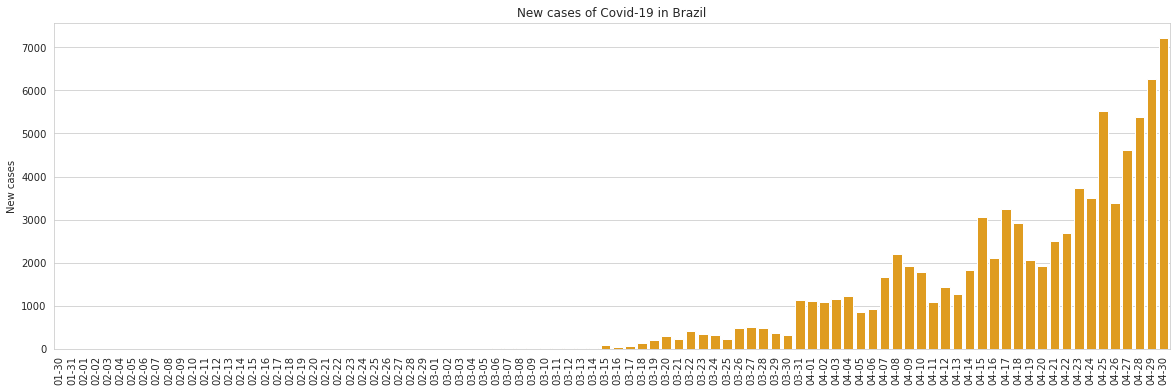

In [9]:
# Set the width and height of the figure
plt.figure(figsize=(20,6))

plt.title("New cases of Covid-19 in Brazil")

sns.barplot(x=cases_day['date'], y=cases_day['new_cases'], color='orange')

plt.xticks(rotation='vertical')
# Add label for vertical axis
plt.xlabel("")
plt.ylabel("New cases")

Text(0, 0.5, 'New cases')

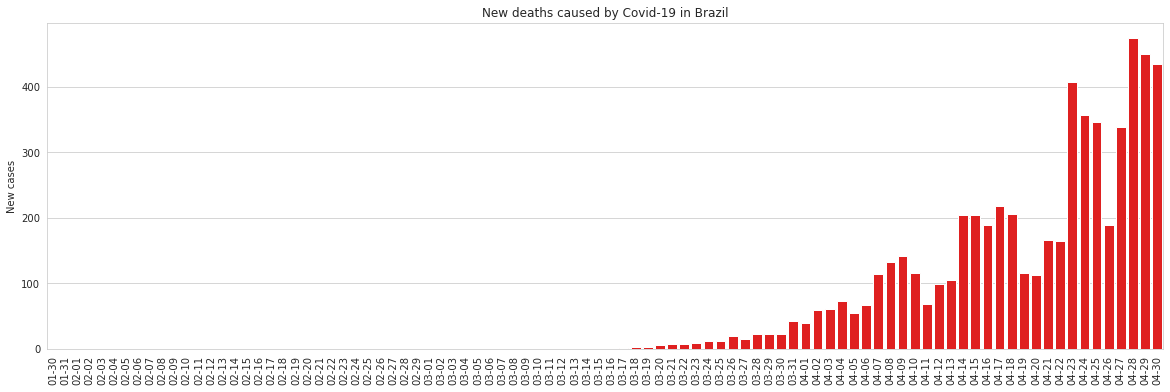

In [10]:
# Set the width and height of the figure
plt.figure(figsize=(20,6))

plt.title("New deaths caused by Covid-19 in Brazil")

sns.barplot(x=cases_day['date'], y=cases_day['new_deaths'], color='red')

plt.xticks(rotation='vertical')
# Add label for vertical axis
plt.xlabel("")
plt.ylabel("New cases")

## By region

In [11]:
cases_region = pd.DataFrame(data.groupby(['state']).sum().reset_index())
cases_region.head()

state  cases  deaths
0      Acre   4705     174
1   Alagoas   7067     398
2     Amapá  11353     312
3  Amazonas  58991    4345
4     Bahia  36303    1137

In [12]:
fp = '../input/brazilianstatesshapefiles/BRA_adm1.shp'
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.drop(['ISO','NAME_0','ID_0','ID_1','HASC_1','CCN_1','CCA_1','TYPE_1','ENGTYPE_1','NL_NAME_1','VARNAME_1'], 
            axis = 1, inplace=True)
map_df.head()

NAME_1                                           geometry
0      Acre  POLYGON ((-73.33251 -7.32488, -73.27482 -7.350...
1   Alagoas  MULTIPOLYGON (((-35.90153 -9.86180, -35.90153 ...
2     Amapá  MULTIPOLYGON (((-50.02403 0.85986, -50.02403 0...
3  Amazonas  POLYGON ((-67.32623 2.02968, -67.30118 1.92997...
4     Bahia  MULTIPOLYGON (((-38.69708 -17.97903, -38.69708...

In [13]:
merged = map_df.set_index('NAME_1').join(cases_region.set_index('state'))
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
merged.head()

geometry  cases  deaths  \
NAME_1                                                                       
Acre      POLYGON ((-73.33251 -7.32488, -73.27482 -7.350...   4705     174   
Alagoas   MULTIPOLYGON (((-35.90153 -9.86180, -35.90153 ...   7067     398   
Amapá     MULTIPOLYGON (((-50.02403 0.85986, -50.02403 0...  11353     312   
Amazonas  POLYGON ((-67.32623 2.02968, -67.30118 1.92997...  58991    4345   
Bahia     MULTIPOLYGON (((-38.69708 -17.97903, -38.69708...  36303    1137   

                                              coords  
NAME_1                                                
Acre         (-70.69109385249948, -9.13325929641718)  
Alagoas    (-36.683728766578014, -9.658471584320012)  
Amapá       (-52.01072304628849, 1.6037504673004435)  
Amazonas  (-63.427048430378576, -3.7719775438308716)  
Bahia     (-42.648035062980156, -13.441805362701388)

In [14]:
merged.describe()

cases        deaths
count      27.000000     27.000000
mean    39816.740741   2480.888889
std     75741.030130   5769.953748
min      1198.000000     26.000000
25%      5177.000000    243.000000
50%     23917.000000    687.000000
75%     31286.500000   1227.000000
max    387539.000000  28975.000000

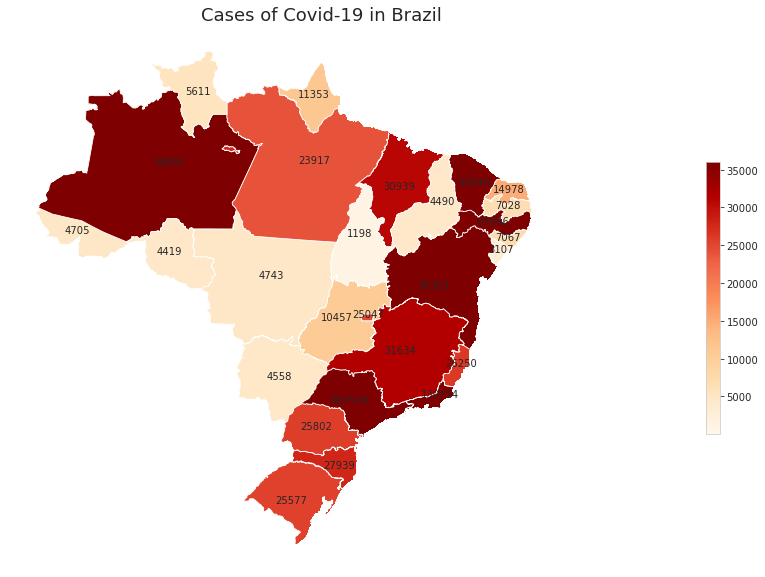

In [15]:
values = 'cases'
vmin, vmax = 26, 36000
fig, ax = plt.subplots(1, figsize=(25, 10))
ax.axis('off')
title = 'Cases of Covid-19 in Brazil'
ax.set_title(title, fontdict={'fontsize': '18', 'fontweight' : '1'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, shrink=0.5)
for idx, row in merged.iterrows():
    plt.annotate(s=row.cases, xy=row['coords'],horizontalalignment='center')
    
merged.plot(column=values, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='1',
            norm=plt.Normalize(vmin=vmin, vmax=vmax))

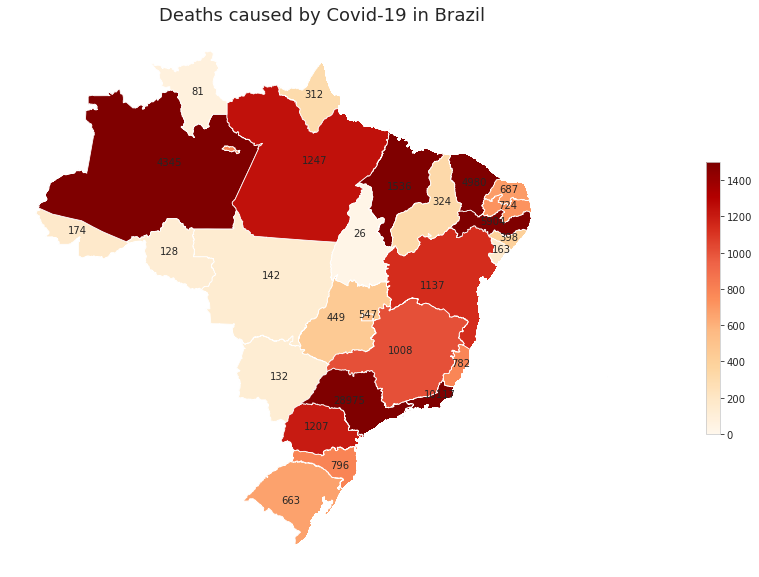

In [16]:
values = 'deaths'
vmin, vmax = 0, 1500
fig, ax = plt.subplots(1, figsize=(25, 10))
ax.axis('off')
title = 'Deaths caused by Covid-19 in Brazil'
ax.set_title(title, fontdict={'fontsize': '18', 'fontweight' : '1'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, shrink=0.5)
for idx, row in merged.iterrows():
    plt.annotate(s=row.deaths, xy=row['coords'],horizontalalignment='center')
    
merged.plot(column=values, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='1',
            norm=plt.Normalize(vmin=vmin, vmax=vmax))

Text(0, 0.5, 'Cases')

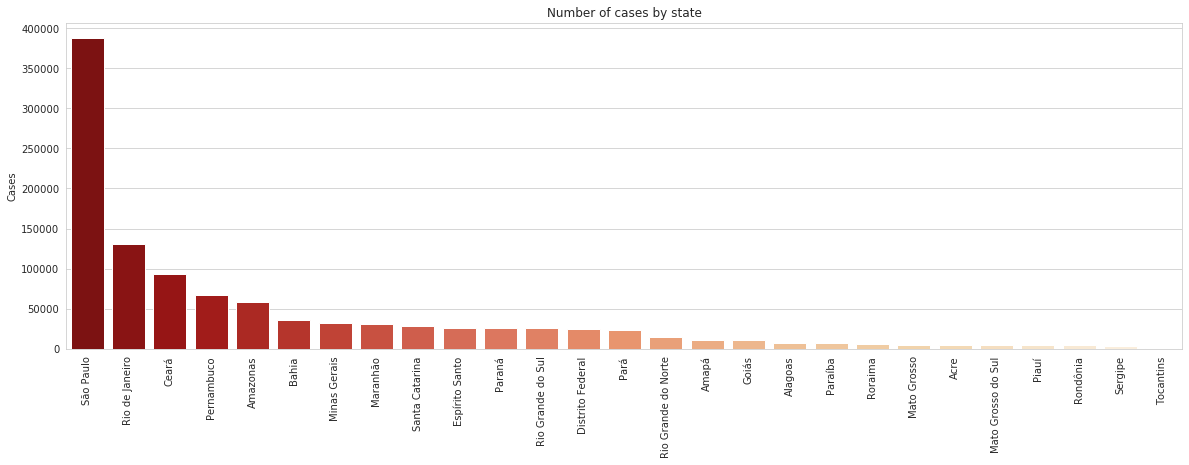

In [17]:
cases_region.sort_values(['cases'], inplace=True, ascending=False)

plt.figure(figsize=(20,6))
plt.title("Number of cases by state")

pal = sns.color_palette("OrRd_r", len(cases_region))
rank = cases_region['cases'].argsort().argsort()  
sns.barplot(x=cases_region.state, y=cases_region.cases, palette=np.array(pal[::-1])[rank])

plt.xticks(rotation='vertical')
plt.xlabel("")
plt.ylabel("Cases")

Text(0, 0.5, 'Cases')

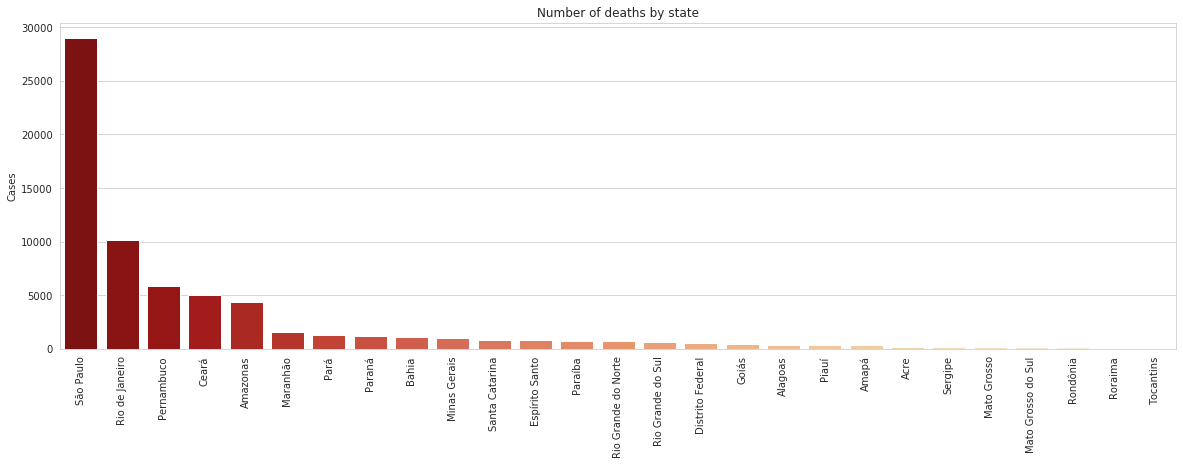

In [18]:
cases_region.sort_values(['deaths'], inplace=True, ascending=False)

plt.figure(figsize=(20,6))
plt.title("Number of deaths by state")

pal = sns.color_palette("OrRd_r", len(cases_region))
rank = cases_region['deaths'].argsort().argsort()  
sns.barplot(x=cases_region.state, y=cases_region.deaths, palette=np.array(pal[::-1])[rank])

plt.xticks(rotation='vertical')
plt.xlabel("")
plt.ylabel("Cases")

Progression of the disease by state

In [19]:
cases_region_2 = pd.DataFrame(data.groupby(['date','state']).sum().reset_index())
cases_region_2.head()

date     state  cases  deaths
0  2020-01-30      Acre      0       0
1  2020-01-30   Alagoas      0       0
2  2020-01-30     Amapá      0       0
3  2020-01-30  Amazonas      0       0
4  2020-01-30     Bahia      0       0

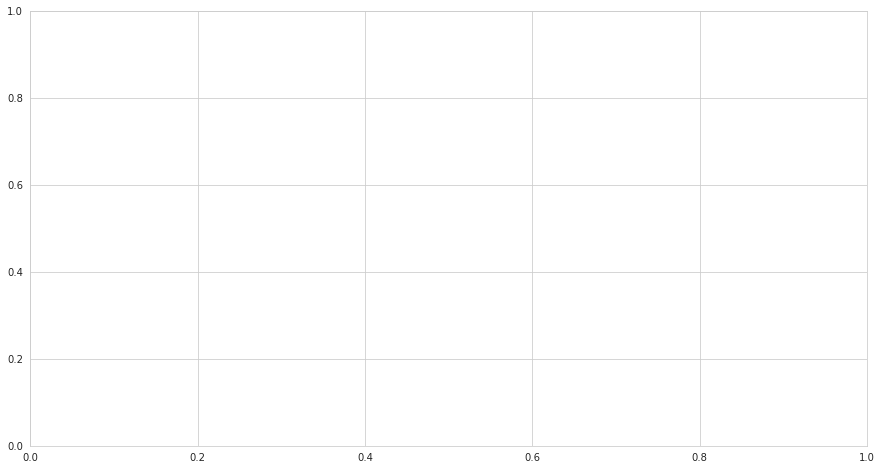

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))
def draw_barchart(date,case="cases"):
    dff= (cases_region_2[cases_region_2['date'].eq(date)].sort_values(by=case,ascending=False).head(10))[::-1]
    ax.clear()
    ax.barh(dff['state'], dff[case], color=["#980505","#CD1212","#D84E4E","#CB6262","#D39B5F","#F7EC10","#D0F710","#9CF710","#B4D67F","#969C8E"][::-1])
    dx = dff[case].max() / 200
    for i, (value, name) in enumerate(zip(dff[case], dff['state'])):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value-dx, i-.25, value, size=10, color='#17202A', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    # ... polished styles
    ax.text(1, 0.4, date, transform=ax.transAxes, color='#777777', size=30, ha='right', weight=800)
    ax.text(0, 1.06, 'Number of cases', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'Progression of the Covid-19 in Brazil up to April 30th, 2020',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    ax.text(1, 0, 'by @Rodolfo Saldanha; credit to @Zubair @jburnmurdoch', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)

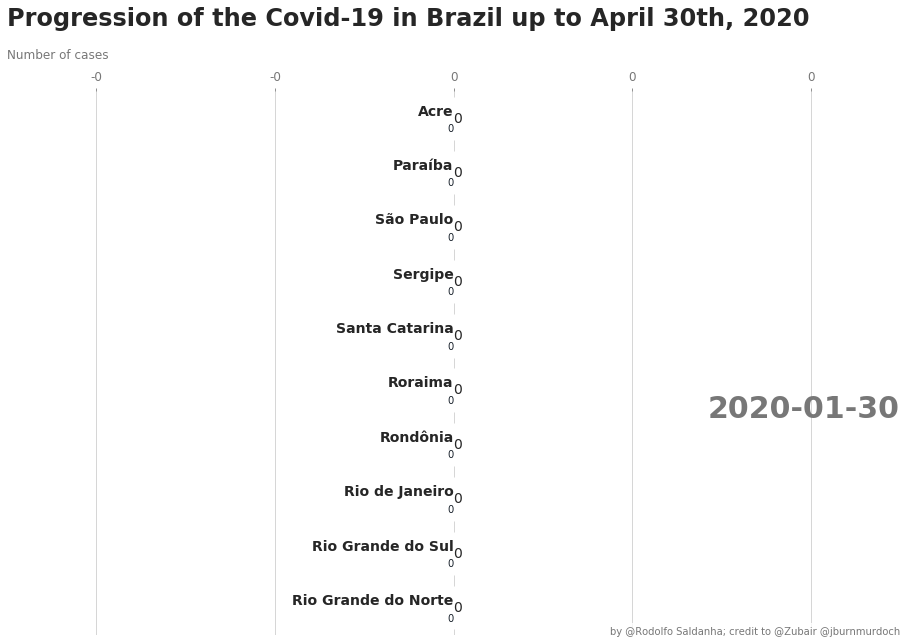

In [21]:
from matplotlib import animation as F
from IPython.display import HTML
fig,ax = plt.subplots(figsize=(16,10)) #Set figure for plot
animator = F.FuncAnimation(fig,draw_barchart,frames=cases_region_2.date.unique(),interval=500) #Building animation
HTML(animator.to_jshtml())

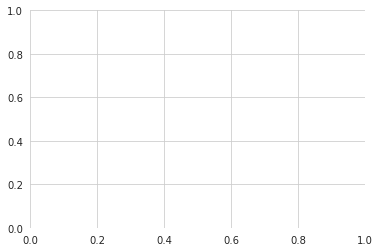

In [22]:
 writergif = F.PillowWriter(fps=3) 
animator.save('animation.gif',writer=writergif)